<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/Human_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Human_prediction**

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#Google colabをマウント
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#画像とラベル表示のための関数を定義

In [0]:
#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = int(os.path.basename(image_path).split(".")[0])　#パスから画像番号を抜き出し
      label = os.path.basename(os.path.dirname(image_path))　#パスからラベルのフォルダ名を抜き出し
      return(image_name, label)


def showImage(image_path):
    #画像のインポート
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    #画像のリサイズ
    height = img.shape[0]
    width = img.shape[1]
    resized_img = cv2.resize(img, (int(width*300/height), 300))
    cv2_imshow(resized_img)

def hum_prediction():
    while True:
        pred = input('ラベルを入力して下さい   '+ class_name[0]+'：「0」、'+class_name[1]+'：「1」')
        if pred == '0':
            hum_pred = class_name[0]
            break
        elif pred == '1':
            hum_pred = class_name[1]
            pred = 1
            break
        else:
            print('0か1を入力して下さい')
    return hum_pred  #class_nameで出力される

#メインプログラム



In [101]:
#ファイル名の取得

image_path = glob.glob("/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/*/*")
#random.shuffle(image_path)  #表示順をランダムにする
print(len(image_path))
print(image_path) 

#対象画像のパスからラベルを抜き出す


#ファイル名よりラベルを抜き出し、'class_name'と定義
class_name = []
class_path = glob.glob('/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/*')
for i in class_path:
    class_name.append(os.path.basename(i))  
print(class_name)


#image_path = image_path[0:5]  #テスト用にデータセットを減らす


128
['/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/grav/5015.jpg', '/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/grav/1503.jpg', '/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/grav/2851.jpg', '/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/grav/6518.jpg', '/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/grav/6147.jpg', '/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/grav/6150.jpg', '/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/grav/893.jpg', '/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/grav/7765.jpg', '/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/grav/4030.jpg', '/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/grav/6764.jpg', '/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/grav/180.jpg', '/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/grav/1396.jpg', '/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val

In [102]:
image_name_list = []
label_list = []

for i in image_path:
    image_name, label = getlabel(i)  #画像の名前とラベルを取得
    image_name_list.append(image_name) #image_nameを番号でリストに格納
    label_list.append(label)

colname = ['image_name','Label','kitaguchi', 'kawasaki'] #evaluatorの名前
df = pd.DataFrame(index=None, columns=colname) #表を作成

df.iloc[:,0] = image_name_list #0列目にラベルを代入する
df.iloc[:,1] = label_list #1列目にラベルを代入する
df = df.sort_values("image_name", ascending=True) #画像番号順に並び替える
df = df.reset_index(drop=True) #インデックスの番号をリセットする

pd.set_option('display.max_rows', 500) #省略なしで表示
print(df)


     image_name Label kitaguchi kawasaki
0            17  grav       NaN      NaN
1            19  grav       NaN      NaN
2            24  grav       NaN      NaN
3            36  grav       NaN      NaN
4            38  cont       NaN      NaN
5            85  cont       NaN      NaN
6           118  cont       NaN      NaN
7           137  cont       NaN      NaN
8           139  cont       NaN      NaN
9           149  cont       NaN      NaN
10          158  cont       NaN      NaN
11          168  cont       NaN      NaN
12          180  grav       NaN      NaN
13          196  cont       NaN      NaN
14          204  cont       NaN      NaN
15          225  cont       NaN      NaN
16          229  cont       NaN      NaN
17          234  cont       NaN      NaN
18          278  cont       NaN      NaN
19          292  cont       NaN      NaN
20          343  cont       NaN      NaN
21          383  cont       NaN      NaN
22          385  grav       NaN      NaN
23          401 

In [90]:
pd.set_option('display.max_rows', 500) #省略せずに出力する
print(df.iloc[:,1])

0    grav
1    grav
2    grav
3    grav
4    grav
Name: Label, dtype: object


In [96]:
path = "/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/grav/2794.jpg"

path = path.split("/")
path = path[len(path)-1]
print(path)

2794.jpg


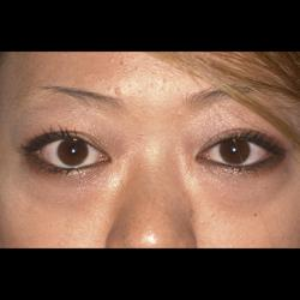

ラベルを入力して下さい   grav：「0」、cont：「1」0


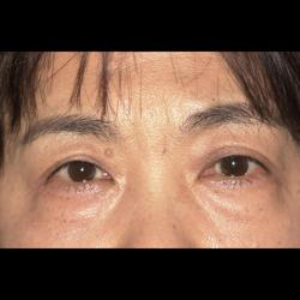

ラベルを入力して下さい   grav：「0」、cont：「1」1


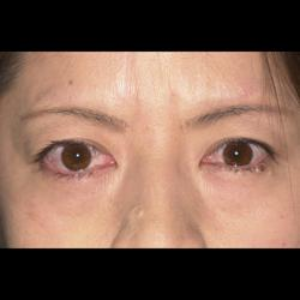

ラベルを入力して下さい   grav：「0」、cont：「1」0


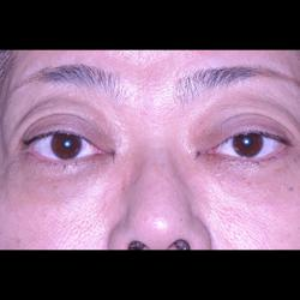

ラベルを入力して下さい   grav：「0」、cont：「1」1


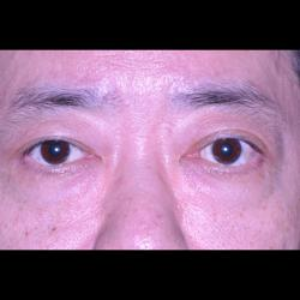

ラベルを入力して下さい   grav：「0」、cont：「1」1


In [91]:
#人による判定

image_path_list = 

for i in image_path:
    showImage(i) #画像を表示
    hum_pred = hum_prediction() #ヒトに判定してもらう

    image_name = int(image_name.split(".")[0])


    '''
    image_name_list.append(image_name)
    label_list.append(label)
    model_pred_list.append(model_pred)
    hum_pred_list.append(hum_pred)
    '''




    

In [0]:
#print(image_name_list)
#print(label_list)
#print(model_pred_list)
#print(hum_pred_list)

#ラベルのリストを表示
df = pd.DataFrame({'image_name':image_name_list, 'label':label_list, 'model_pred':model_pred_list, 'hum_pred':hum_pred_list})
print(df)

#CSV形式で保存
df.to_csv('/content/drive/My Drive/Deep_learning/applstra/ModelHumPred_result.csv')

               image_name label model_pred hum_pred
0       top_about2new.jpg  stra       stra     stra
1     shironefruits04.jpg  stra       stra     appl
2  town20191011152132.jpg  appl       appl     stra
3              ringo1.jpg  appl       appl     appl
4  top_img_ichigo2019.jpg  stra       stra     stra


#1例ずつ各ラベルを表示する

Image: top_about2new.jpg
Label: stra
Model_pred: stra
hum_pred: stra


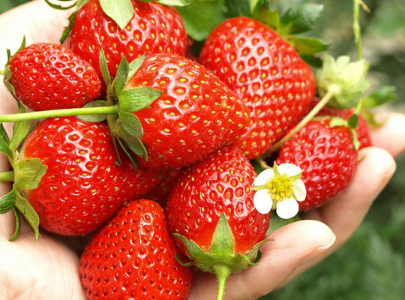


Image: shironefruits04.jpg
Label: stra
Model_pred: stra
hum_pred: appl


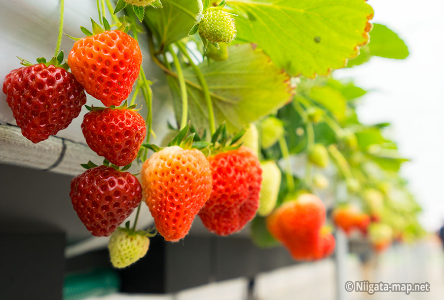


Image: town20191011152132.jpg
Label: appl
Model_pred: appl
hum_pred: stra


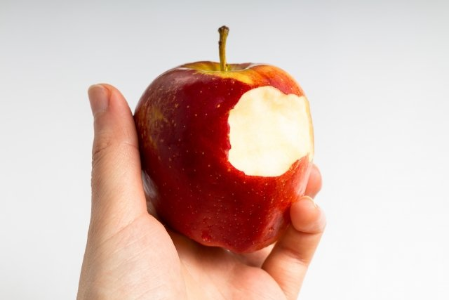


Image: ringo1.jpg
Label: appl
Model_pred: appl
hum_pred: appl


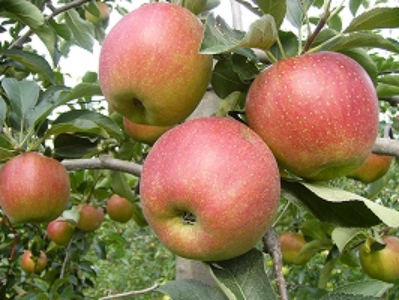


Image: top_img_ichigo2019.jpg
Label: stra
Model_pred: stra
hum_pred: stra


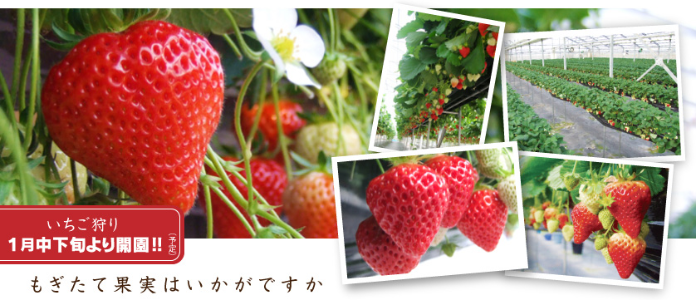

In [0]:
#Image_nameとラベルは、表を参照して表示する
k=0
for i in image_path:
    print('Image: '+ df.iloc[k,0])
    print('Label: '+ df.iloc[k,1])
    print('Model_pred: '+ df.iloc[k,2])
    print('hum_pred: '+ df.iloc[k,3])
    showImage(i)  #画像を表示
    print() #空白行を入れる
    time.sleep(0.1)
    k += 1


#ヒトが間違えたもののみ表示する

Image: shironefruits04.jpg
Label: stra
Model_pred: stra
hum_pred: appl


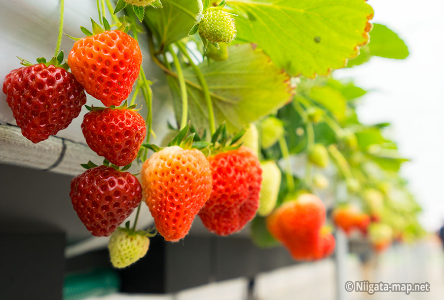


Image: town20191011152132.jpg
Label: appl
Model_pred: appl
hum_pred: stra


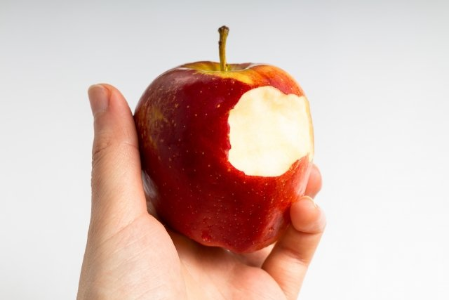

In [0]:
#Image_nameとラベルは、表を参照して表示する
k=0
for i in image_path:
    if df.iloc[k,1] != df.iloc[k,3]:
        print('Image: '+ df.iloc[k,0])
        print('Label: '+ df.iloc[k,1])
        print('Model_pred: '+ df.iloc[k,2])
        print('hum_pred: '+ df.iloc[k,3])
        showImage(i)  #画像を表示
        print() #空白行を入れる
        time.sleep(0.1)
    else:
        pass
    k+=1
